## Test models

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('../')
print(os.getcwd())

/home/yyjau/Documents/deepSfm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import torch
from tqdm import tqdm

## Test model 

In [4]:
from IPython.display import clear_output
clear_output(wait=True)
from models.SuperPointNet_gauss2 import main as test_module
test_module()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 320]             640
       BatchNorm2d-2         [-1, 64, 240, 320]             128
              ReLU-3         [-1, 64, 240, 320]               0
            Conv2d-4         [-1, 64, 240, 320]          36,928
       BatchNorm2d-5         [-1, 64, 240, 320]             128
              ReLU-6         [-1, 64, 240, 320]               0
       double_conv-7         [-1, 64, 240, 320]               0
            inconv-8         [-1, 64, 240, 320]               0
         MaxPool2d-9         [-1, 64, 120, 160]               0
           Conv2d-10         [-1, 64, 120, 160]          36,928
      BatchNorm2d-11         [-1, 64, 120, 160]             128
             ReLU-12         [-1, 64, 120, 160]               0
           Conv2d-13         [-1, 64, 120, 160]          36,928
      BatchNorm2d-14         [-1, 64, 1

 44%|████▍     | 22/50 [00:00<00:00, 218.66it/s]

outs:  ['semi', 'desc', 'pts_int', 'pts_offset', 'pts_desc']
semi :  torch.Size([2, 65, 15, 20])
desc :  torch.Size([2, 256, 15, 20])
pts_int :  torch.Size([2, 500, 2])
pts_offset :  torch.Size([2, 500, 2])
pts_desc :  torch.Size([2, 500, 256])
Start timer!


  8%|▊         | 4/50 [00:00<00:01, 38.96it/s]

forward only:  197.74752008448687  iter/s
Start timer!


 28%|██▊       | 14/50 [00:00<00:00, 41.55it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 1.11 GiB already allocated; 22.56 MiB free; 18.84 MiB cached)

## Test model process_output

In [8]:
from Val_model_subpixel import Val_model_subpixel
if __name__ == '__main__':
    filename = 'configs/magicpoint_repeatability_heatmap.yaml'
    import yaml
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    torch.set_default_tensor_type(torch.FloatTensor)
    with open(filename, 'r') as f:
        config = yaml.load(f)
    # data loading
    from utils.loader import dataLoader_test as dataLoader
    task = config['data']['dataset']
    data = dataLoader(config, dataset=task)
    test_set, test_loader = data['test_set'], data['test_loader']

    from utils.print_tool import datasize
    datasize(test_loader, config, tag='test')

    # model loading
    from utils.loader import get_module
    Val_model_heatmap = get_module('', config['front_end_model'])

    ## load pretrained
    val_agent = Val_model_heatmap(config['model'], device=device)
    val_agent.loadModel()
    
    net = val_agent.net
    # load data
    for i, sample in tqdm(enumerate(test_loader)):
        img_0, img_1 = sample['image'], sample['warped_image']
        if i>1: break

/home/yyjau/anaconda3/envs/py36-torch1.1-cuda10/lib/python3.6/site-packages/ipykernel_launcher.py:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  if __name__ == '__main__':
1it [00:00,  4.94it/s]


In [9]:
img_pair = torch.cat((img_0, img_1), dim=0)
print("img_pair: ", img_pair.shape)

img_pair:  torch.Size([2, 1, 240, 320])


In [10]:

outs = net(img_pair.to(device))
print("outs: ", list(outs))
# process outputs
from utils.print_tool import print_dict_attr
print_dict_attr(outs, 'shape')

from models.model_utils import SuperPointNet_process 
params = {
    'out_num_points': 500,
    'patch_size': 5,
    'device': device,
    'nms_dist': 4,
    'conf_thresh': 0.015
}

sp_processer = SuperPointNet_process(**params)
outs_post = net.process_output(sp_processer)

print("outs: ", list(outs_post))
from utils.print_tool import print_dict_attr
print_dict_attr(outs_post, 'shape')

outs:  ['semi', 'desc']
semi :  torch.Size([2, 65, 30, 40])
desc :  torch.Size([2, 256, 30, 40])
outs:  ['semi', 'desc', 'pts_int', 'pts_offset', 'pts_desc']
semi :  torch.Size([2, 65, 30, 40])
desc :  torch.Size([2, 256, 30, 40])
pts_int :  torch.Size([2, 500, 2])
pts_offset :  torch.Size([2, 500, 2])
pts_desc :  torch.Size([2, 500, 256])


In [32]:
# test runtime error
net.output['semi'] = torch.zeros((2,65,30,40)).cuda() * torch.tensor(np.nan).cuda()
def set_nan2zero(tens, name = 'network'):
    mat_nans = (tens != tens)
    n_nans = mat_nans.sum()
    if n_nans > 0:
        logging.warning(f"{name} include {n_nans} nans!!")
    tens[mat_nans] = 0 
    return tens

net.output['semi'] = set_nan2zero(net.output['semi'], 'semi output')

outs_post = net.process_output(sp_processer)
print_dict_attr(outs_post, 'shape')

semi :  torch.Size([2, 65, 30, 40])
desc :  torch.Size([2, 256, 30, 40])
pts_int :  torch.Size([2, 500, 2])
pts_offset :  torch.Size([2, 500, 2])
pts_desc :  torch.Size([2, 500, 256])


In [11]:
pts_int = outs_post['pts_int']
pts_offset = outs_post['pts_offset']
pts_desc = outs_post['pts_desc']
print("pts_offset: ", pts_offset[0, :5, :])
def print_attr(dictionary, attr):
    for en in list(dictionary):
        print(en, attr, ": ", getattr(dictionary[en], attr))
print_attr(outs_post, 'requires_grad')
# print("pts_offset requires_grad: ", pts_offset.requires_grad)

pts_offset:  tensor([[-0.2935, -0.0379],
        [-0.2112, -0.0907],
        [ 0.1564, -0.3346],
        [-0.2292,  0.2241],
        [ 0.4943, -0.4081]], device='cuda:0', grad_fn=<SliceBackward>)
semi requires_grad :  True
desc requires_grad :  True
pts_int requires_grad :  False
pts_offset requires_grad :  True
pts_desc requires_grad :  True


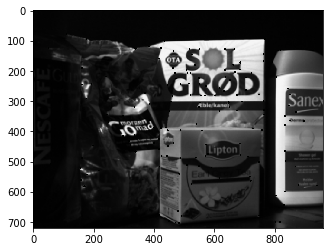

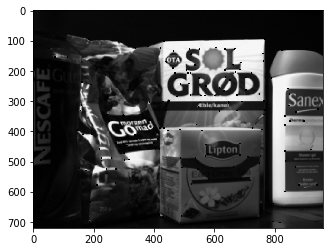

In [12]:
from utils.draw import draw_keypoints
from utils.utils import toNumpy
for i in range(2):
    img = draw_keypoints(toNumpy(img_pair[i].squeeze()), toNumpy((pts_int[i]+pts_offset[i]).squeeze()).transpose())
    # print("img: ", img_0)
    plt.imshow(img)
    plt.show()

### get matches

matches:  (4, 105)
#Matches = 105


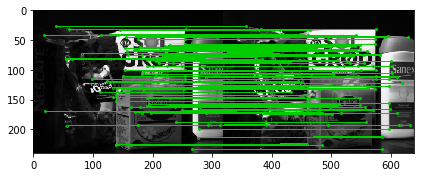

In [13]:
from models.model_wrap import PointTracker

tracker = PointTracker(max_length=2, nn_thresh=val_agent.nn_thresh)

for i in range(2):
    f = lambda x: toNumpy(x.squeeze())
    tracker.update(f(pts_int[i]).transpose(), f(pts_desc[i]).transpose())
    
matches = tracker.get_matches().T
print("matches: ", matches.transpose().shape)

from utils.draw import draw_matches
# filename = path_match + '/' + f_num + 'm.png'
draw_matches(f(img_pair[0]), f(img_pair[1]), matches, filename='')

### box nms

nms_batch:  torch.Size([240, 320])


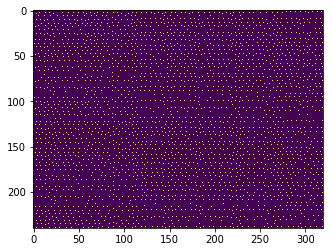

In [16]:
from utils.utils import box_nms
nms_dist = config['model']['nms'] # 4
conf_thresh = config['model']['detection_threshold']
semi_flat_tensor = torch.ones((1,1,240, 320))
nms_batch = box_nms(semi_flat_tensor.squeeze(), nms_dist, min_prob=conf_thresh).cpu()
print("nms_batch: ", nms_batch.shape)

plt.imshow(nms_batch)

## Test model frontend

In [ ]:
from Val_model_subpixel import Val_model_subpixel
if __name__ == '__main__':
    filename = 'configs/magicpoint_repeatability.yaml'
    import yaml
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    torch.set_default_tensor_type(torch.FloatTensor)
    with open(filename, 'r') as f:
        config = yaml.load(f)

    task = config['data']['dataset']
    # data loading
    from utils.loader import dataLoader_test as dataLoader
    data = dataLoader(config, dataset='hpatches')
    test_set, test_loader = data['test_set'], data['test_loader']

    # take one sample
    for i, sample in tqdm(enumerate(test_loader)):
        if i>1: break

        val_agent = Val_model_subpixel(config['subpixel'], device=device)
        val_agent.loadModel()
        # points from heatmap
        img = sample['image']
        print("image: ", img.shape)
        points = torch.tensor([[1,2], [3,4]])
        def points_to_4d(points):
            num_of_points = points.shape[0]
            cols = torch.zeros(num_of_points, 1).float()
            points = torch.cat((cols, cols, points.float()), dim=1)
            return points
        label_idx = points_to_4d(points)
        # concat points to be (batch, 0, y, x)
        patches = val_agent.extract_patches(label_idx, img)
        points_res = val_agent.run(patches)
        ###
        print('label_idx: ', label_idx)
        print('points_res: ', points_res)

## extract points from img

In [6]:
## extract points from img
print("config: ", config)
from models.model_wrap import SuperPointFrontend_torch
path = config['pretrained']
nms_dist = config['model']['nms'] # 4
conf_thresh = config['model']['detection_threshold']
nn_thresh = config['model']['nn_thresh']
fe = SuperPointFrontend_torch(config=config, weights_path=path,
                        nms_dist=nms_dist,
                        conf_thresh=conf_thresh,
                        nn_thresh=nn_thresh,
                        cuda=False,
                        device=device)
print('==> Successfully loaded pre-trained network.')
print(path)


config:  {'data': {'name': 'patches_dataset', 'dataset': 'hpatches', 'alteration': 'all', 'preprocessing': {'resize': [240, 320]}}, 'model': {'subpixel': {'enable': False}, 'batch_size': 1, 'eval_batch_size': 50, 'learning_rate': 0.001, 'detection_threshold': 0.015, 'nms': 4, 'top_k': 1000, 'nn_thresh': 1.0, 'homography_adaptation': {'num': 0}}, 'pretrained': 'logs/superpoint_coco40_16/checkpoints/superPointNet_170000_checkpoint.pth.tar', 'subpixel': {'enable': True, 'name': 'SubpixelPatchNet', 'params': {'patch_size': 32}, 'pretrained': 'logs/subpixel_syn1_1/checkpoints/superPointNet_50000_checkpoint.pth.tar'}, 'eval_iter': 1000}
model structure: relu - bn - conv
apply batch norm!
==> Successfully loaded pre-trained network.
logs/superpoint_coco40_16/checkpoints/superPointNet_170000_checkpoint.pth.tar


In [7]:
from utils.var_dim import tensorto4d

pts, desc, _, heatmap = fe.run(tensorto4d(img))
print("pts[0]", pts[0].shape)
print("pts[0] max", pts[0].max(axis=1))
pts = pts[0]

pts[0] (3, 490)
pts[0] max [315.         235.           0.62401742]


/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [8]:
## subpixel prediction
verbose=True
from utils.losses import points_to_4d
from utils.var_dim import squeezeToNumpy
##### check #####
pts_switch = lambda points: torch.stack((points[:,1], points[:,0]), dim=1) # (N, (x, y)) --> (N, (y, x))
######
label_idx = points_to_4d(pts_switch(torch.tensor(pts[:2,:].transpose())))
# concat points to be (batch, 0, y, x)
patches = val_agent.extract_patches(label_idx, img)
points_res = val_agent.run(patches) # prediction: (y, x)
points_res = torch.stack((points_res[:,1], points_res[:,0]), dim=1) # (x, y)
if verbose:
    print("points_res: ", points_res.shape)
    print("points_res: ", points_res[:5])
    print("before pts: ", pts.shape)
    print("before pts: ", pts[:,:5])
pts[:2] += squeezeToNumpy(points_res).transpose()
if verbose: print("after pts: ", pts[:,:5])

points_res:  torch.Size([490, 2])
points_res:  tensor([[-0.1303, -0.0532],
        [ 0.0577, -0.0247],
        [ 0.2586,  0.0732],
        [ 0.0979,  0.4007],
        [ 0.2398,  0.1147]], device='cuda:0')
before pts:  (3, 490)
before pts:  [[ 65.         165.         262.         237.          77.        ]
 [ 83.         184.          65.         179.          44.        ]
 [  0.62401742   0.61680508   0.61311173   0.56245947   0.56104898]]
after pts:  [[ 64.86970028 165.05772336 262.25861958 237.09788625  77.23981149]
 [ 82.946843   183.97525391  65.0732339  179.40074107  44.11465476]
 [  0.62401742   0.61680508   0.61311173   0.56245947   0.56104898]]


res (x, y):  tensor([-0.1303, -0.0532], device='cuda:0')


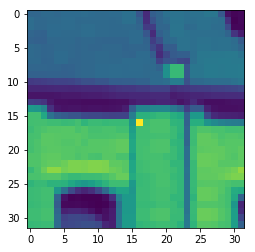

res (x, y):  tensor([ 0.0577, -0.0247], device='cuda:0')


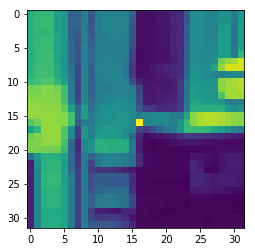

res (x, y):  tensor([0.2586, 0.0732], device='cuda:0')


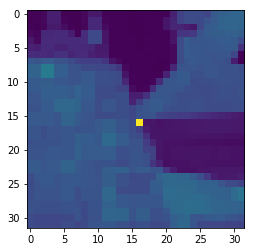

res (x, y):  tensor([0.0979, 0.4007], device='cuda:0')


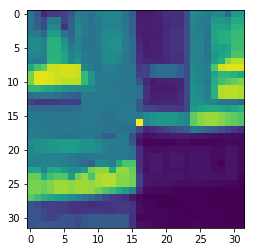

res (x, y):  tensor([0.2398, 0.1147], device='cuda:0')


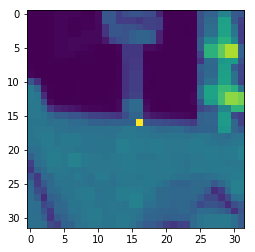

res (x, y):  tensor([ 0.0495, -0.0864], device='cuda:0')


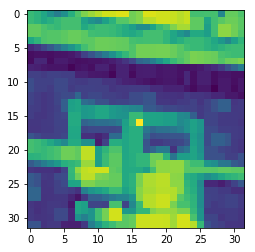

res (x, y):  tensor([0.0568, 0.2229], device='cuda:0')


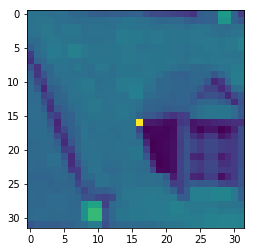

res (x, y):  tensor([0.0564, 0.5063], device='cuda:0')


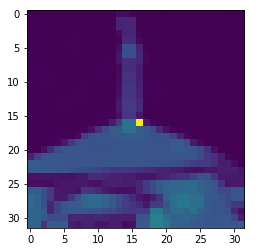

res (x, y):  tensor([-0.1769,  0.1403], device='cuda:0')


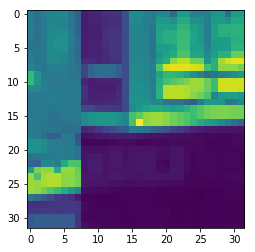

res (x, y):  tensor([-0.1884,  0.1505], device='cuda:0')


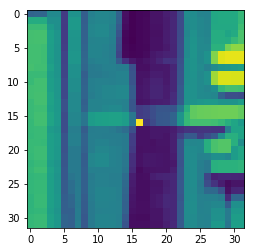

res (x, y):  tensor([ 0.0789, -0.2777], device='cuda:0')


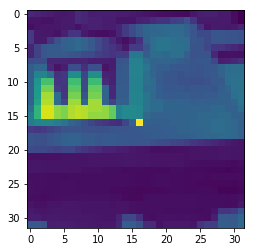

res (x, y):  tensor([0.2767, 0.2957], device='cuda:0')


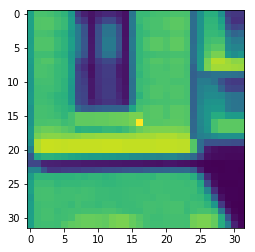

res (x, y):  tensor([0.1495, 0.1687], device='cuda:0')


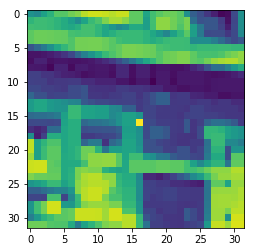

res (x, y):  tensor([-0.0664, -0.0056], device='cuda:0')


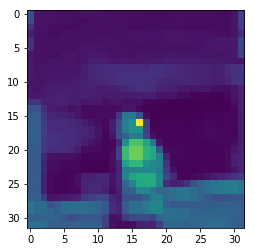

res (x, y):  tensor([-0.0747,  0.2282], device='cuda:0')


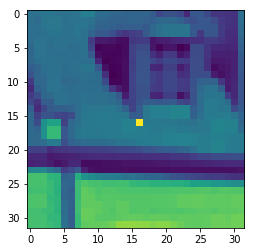

res (x, y):  tensor([0.1565, 0.0596], device='cuda:0')


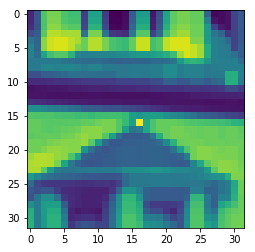

res (x, y):  tensor([-0.1871, -0.1341], device='cuda:0')


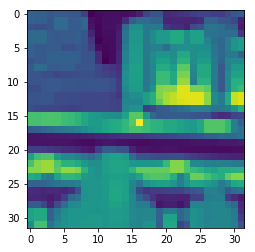

res (x, y):  tensor([-0.2068, -0.3960], device='cuda:0')


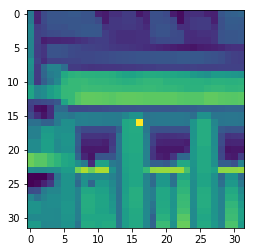

res (x, y):  tensor([-0.0048, -0.1660], device='cuda:0')


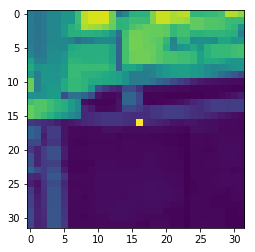

res (x, y):  tensor([0.0107, 0.2733], device='cuda:0')


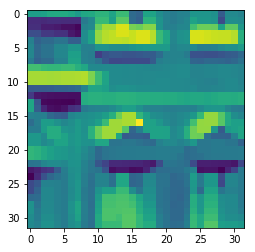

res (x, y):  tensor([-0.0468,  0.1511], device='cuda:0')


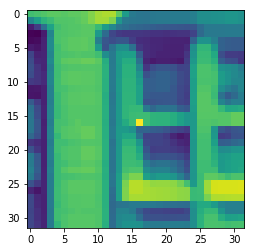

res (x, y):  tensor([0.3224, 0.2237], device='cuda:0')


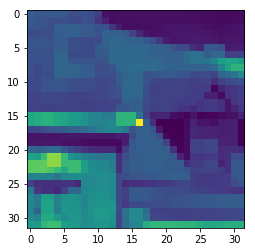

res (x, y):  tensor([-0.0873,  0.0626], device='cuda:0')


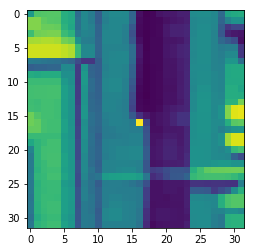

res (x, y):  tensor([ 0.2226, -0.0155], device='cuda:0')


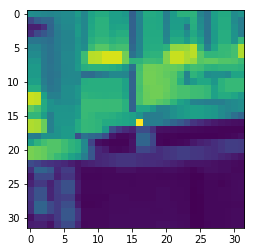

res (x, y):  tensor([0.4676, 0.1746], device='cuda:0')


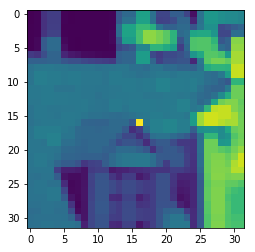

res (x, y):  tensor([-0.2588, -0.3990], device='cuda:0')


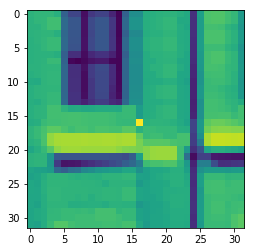

res (x, y):  tensor([-0.3872,  0.1830], device='cuda:0')


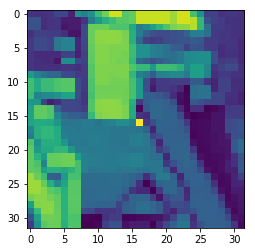

res (x, y):  tensor([-0.0688, -0.1812], device='cuda:0')


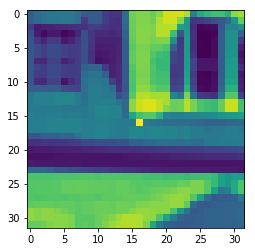

res (x, y):  tensor([ 0.3422, -0.1977], device='cuda:0')


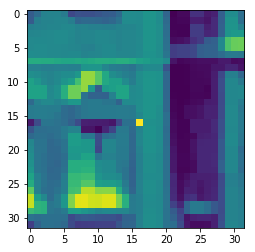

res (x, y):  tensor([-0.1962,  0.2044], device='cuda:0')


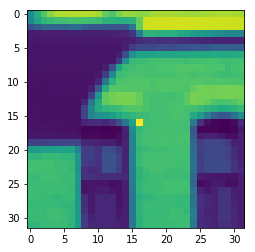

res (x, y):  tensor([-0.4751,  0.0511], device='cuda:0')


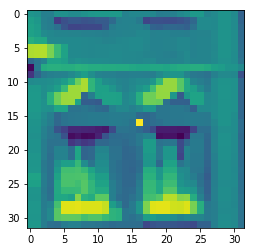

res (x, y):  tensor([-0.0644,  0.1803], device='cuda:0')


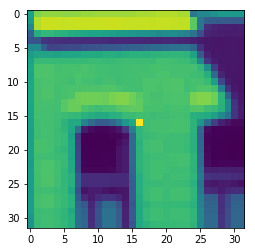

res (x, y):  tensor([-0.3367, -0.1422], device='cuda:0')


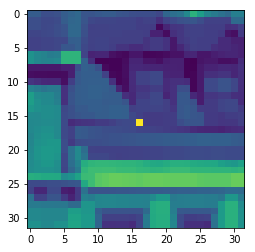

res (x, y):  tensor([-0.3329, -0.0178], device='cuda:0')


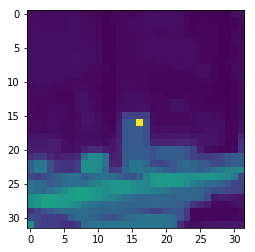

res (x, y):  tensor([0.1659, 0.0441], device='cuda:0')


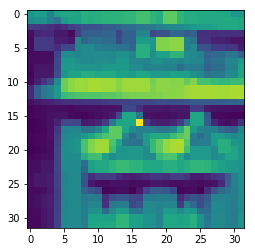

res (x, y):  tensor([-0.1892, -0.1212], device='cuda:0')


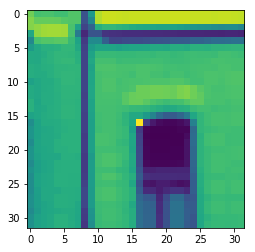

res (x, y):  tensor([0.1867, 0.0593], device='cuda:0')


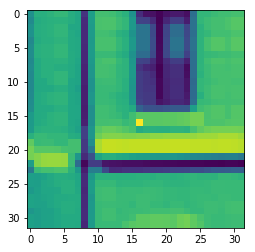

res (x, y):  tensor([0.2284, 0.1525], device='cuda:0')


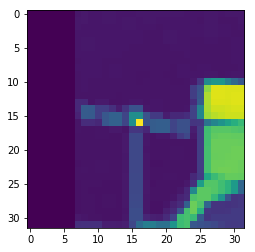

res (x, y):  tensor([0.0534, 0.1839], device='cuda:0')


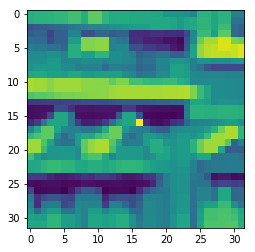

res (x, y):  tensor([ 0.3849, -0.0915], device='cuda:0')


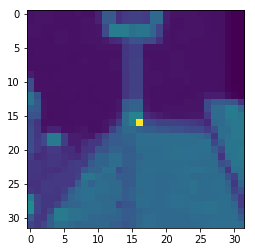

res (x, y):  tensor([ 0.1019, -0.0064], device='cuda:0')


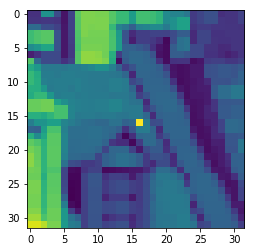

res (x, y):  tensor([-0.1510,  0.3667], device='cuda:0')


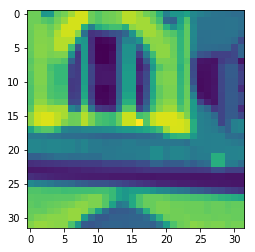

res (x, y):  tensor([ 0.0479, -0.0936], device='cuda:0')


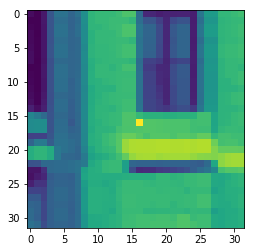

res (x, y):  tensor([0.1003, 0.0402], device='cuda:0')


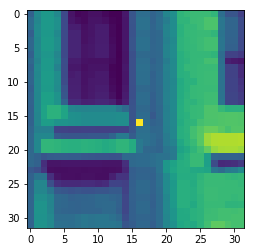

res (x, y):  tensor([-0.2084, -0.0094], device='cuda:0')


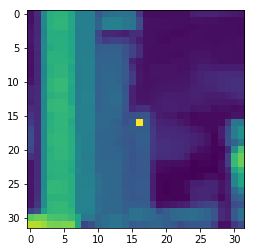

res (x, y):  tensor([ 0.2080, -0.2048], device='cuda:0')


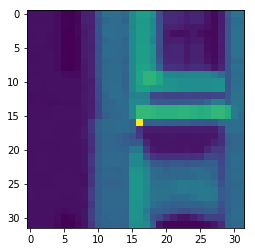

res (x, y):  tensor([-0.3077, -0.0858], device='cuda:0')


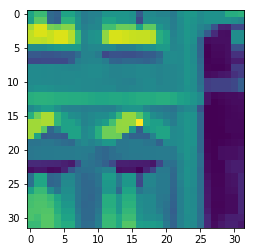

res (x, y):  tensor([ 0.0711, -0.0627], device='cuda:0')


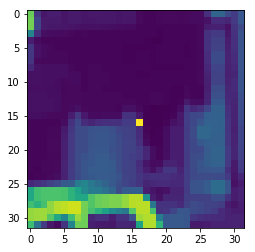

res (x, y):  tensor([-0.1642,  0.0704], device='cuda:0')


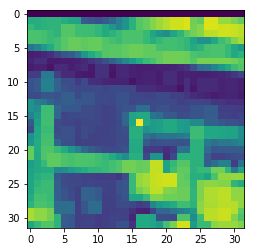

res (x, y):  tensor([0.3630, 0.1177], device='cuda:0')


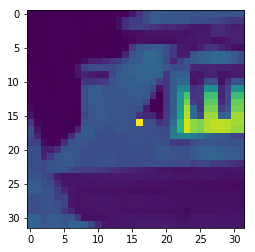

res (x, y):  tensor([-0.4249,  0.0752], device='cuda:0')


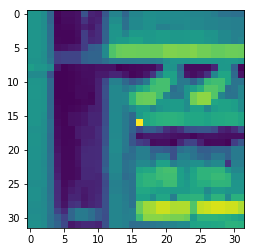

res (x, y):  tensor([-0.0816,  0.0209], device='cuda:0')


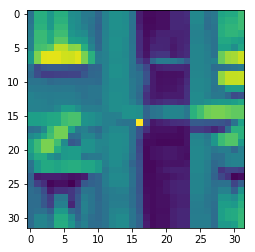

res (x, y):  tensor([ 0.0202, -0.1278], device='cuda:0')


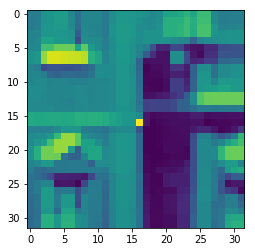

res (x, y):  tensor([-0.1294,  0.3547], device='cuda:0')


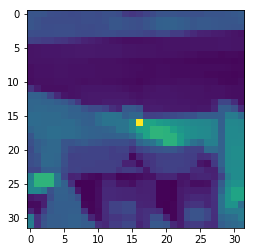

res (x, y):  tensor([0.2691, 0.1891], device='cuda:0')


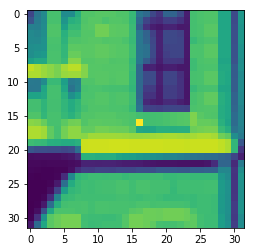

res (x, y):  tensor([ 0.3772, -0.2772], device='cuda:0')


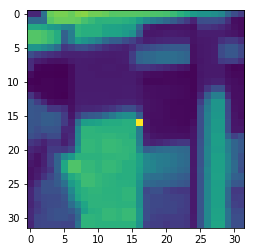

res (x, y):  tensor([0.2453, 0.1028], device='cuda:0')


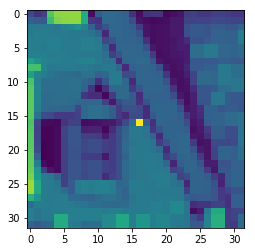

res (x, y):  tensor([ 0.1209, -0.1689], device='cuda:0')


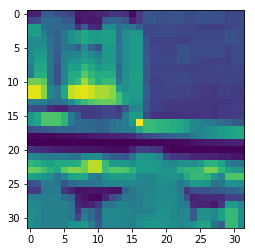

res (x, y):  tensor([-0.1122, -0.2857], device='cuda:0')


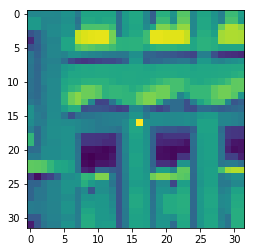

res (x, y):  tensor([0.0485, 0.3150], device='cuda:0')


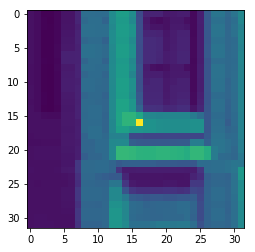

res (x, y):  tensor([-0.0385,  0.2476], device='cuda:0')


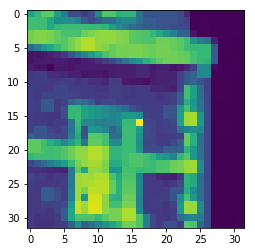

res (x, y):  tensor([-0.2284,  0.0376], device='cuda:0')


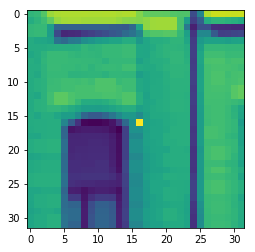

res (x, y):  tensor([ 0.0414, -0.1548], device='cuda:0')


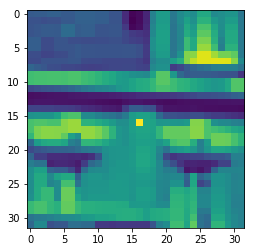

res (x, y):  tensor([-0.1053, -0.2002], device='cuda:0')


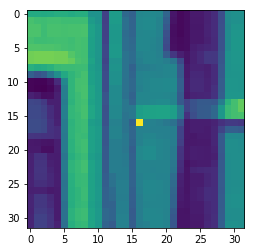

res (x, y):  tensor([-0.0355,  0.2963], device='cuda:0')


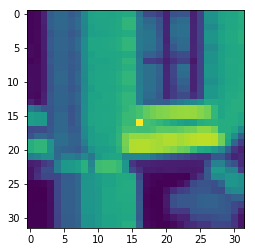

res (x, y):  tensor([0.2899, 0.1190], device='cuda:0')


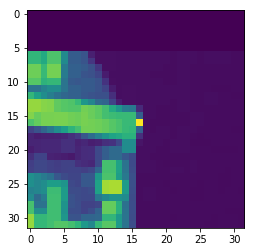

res (x, y):  tensor([-0.0643,  0.0172], device='cuda:0')


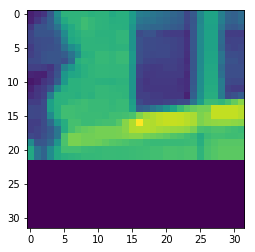

res (x, y):  tensor([ 0.0786, -0.0461], device='cuda:0')


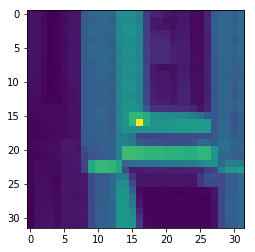

res (x, y):  tensor([-0.3087,  0.1995], device='cuda:0')


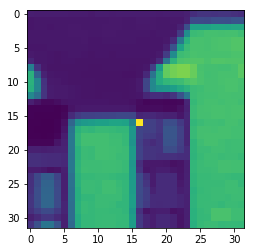

res (x, y):  tensor([0.0415, 0.0061], device='cuda:0')


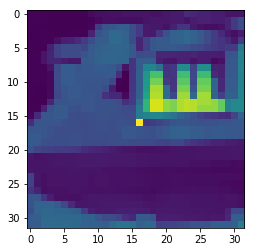

res (x, y):  tensor([ 0.1647, -0.3530], device='cuda:0')


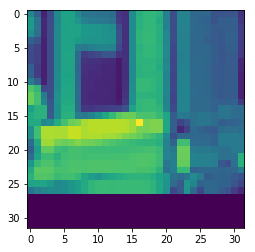

res (x, y):  tensor([-0.0332,  0.2493], device='cuda:0')


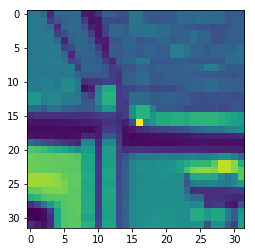

res (x, y):  tensor([ 0.2709, -0.1303], device='cuda:0')


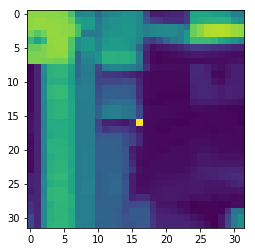

res (x, y):  tensor([ 0.4212, -0.0940], device='cuda:0')


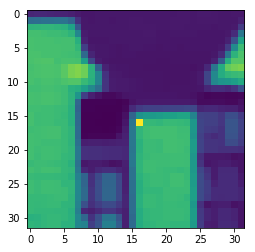

res (x, y):  tensor([-0.0039,  0.0783], device='cuda:0')


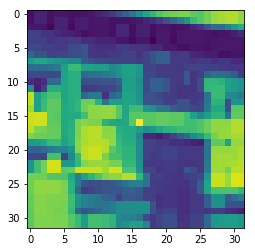

res (x, y):  tensor([-0.0791,  0.1075], device='cuda:0')


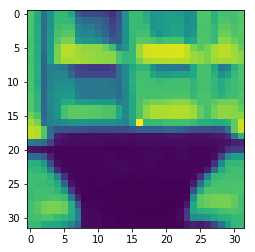

res (x, y):  tensor([-0.0449,  0.2010], device='cuda:0')


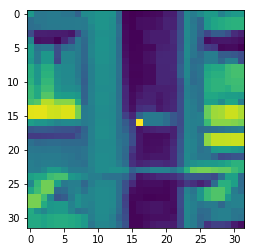

res (x, y):  tensor([-0.0329,  0.3596], device='cuda:0')


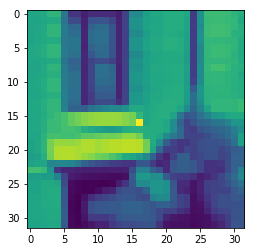

res (x, y):  tensor([0.2401, 0.0540], device='cuda:0')


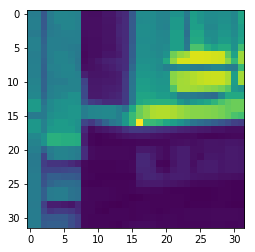

res (x, y):  tensor([0.3078, 0.0571], device='cuda:0')


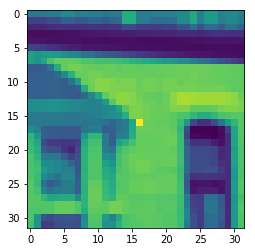

res (x, y):  tensor([-0.0146, -0.0514], device='cuda:0')


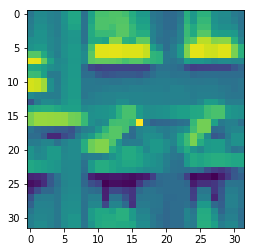

res (x, y):  tensor([-0.1289,  0.0716], device='cuda:0')


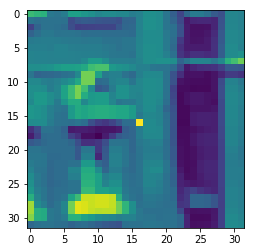

res (x, y):  tensor([-0.3127, -0.3734], device='cuda:0')


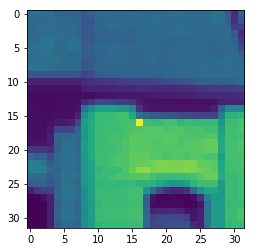

res (x, y):  tensor([-0.1478, -0.2648], device='cuda:0')


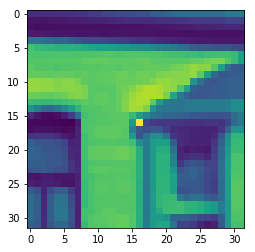

res (x, y):  tensor([-0.0379, -0.6259], device='cuda:0')


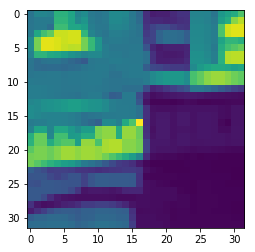

res (x, y):  tensor([ 0.1680, -0.1283], device='cuda:0')


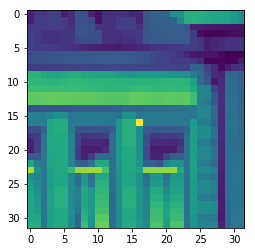

res (x, y):  tensor([0.0195, 0.0866], device='cuda:0')


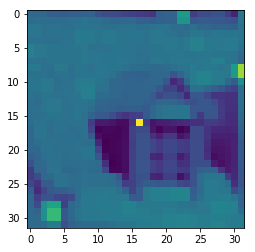

res (x, y):  tensor([-0.0347,  0.0589], device='cuda:0')


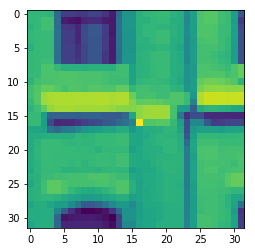

res (x, y):  tensor([-0.1912,  0.1287], device='cuda:0')


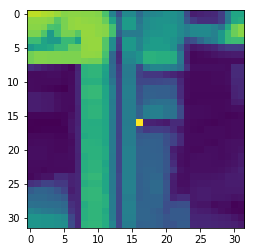

res (x, y):  tensor([ 0.2533, -0.0982], device='cuda:0')


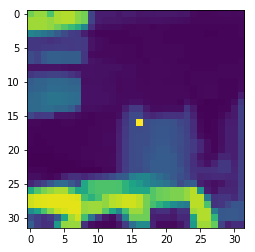

res (x, y):  tensor([0.3180, 0.0350], device='cuda:0')


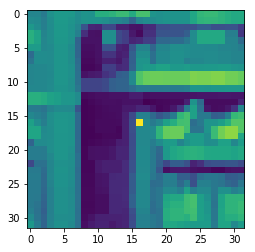

res (x, y):  tensor([ 0.1280, -0.0161], device='cuda:0')


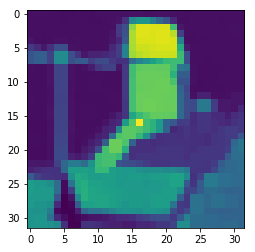

res (x, y):  tensor([-0.2770, -0.0516], device='cuda:0')


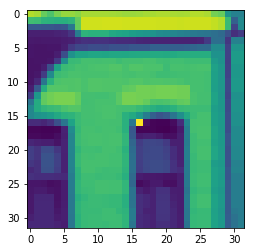

res (x, y):  tensor([-0.3550, -0.1159], device='cuda:0')


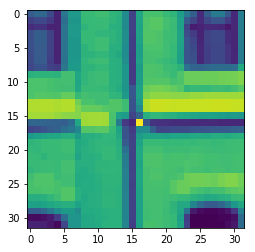

res (x, y):  tensor([0.3177, 0.0448], device='cuda:0')


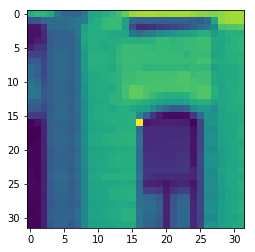

res (x, y):  tensor([-0.0408,  0.0540], device='cuda:0')


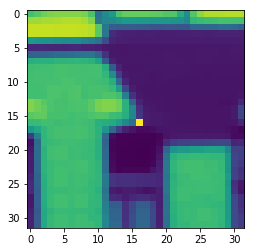

res (x, y):  tensor([0.0631, 0.0315], device='cuda:0')


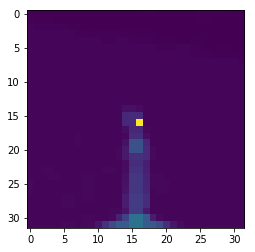

res (x, y):  tensor([-0.2757, -0.3320], device='cuda:0')


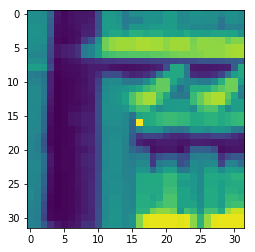

res (x, y):  tensor([-0.0123,  0.0657], device='cuda:0')


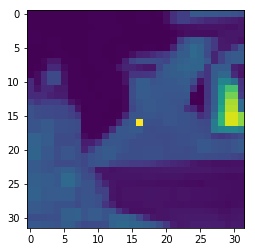

res (x, y):  tensor([0.0956, 0.0459], device='cuda:0')


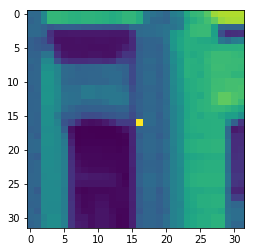

In [9]:
# print patches
def draw_center(patch, pos):
    patch[...,pos,pos] = 1
    return patch

from utils.var_dim import toNumpy
for i in range(100):
    img_id = i
    print("res (x, y): ", points_res[i])
    plt.imshow(draw_center(toNumpy(patches[img_id,0,:,:]), 16))
    plt.show()

In [10]:
img = sample['image']
print("image: ", img.shape)
points = torch.tensor([[1,2], [3,4]])
def points_to_4d(points):
    num_of_points = points.shape[0]
    cols = torch.zeros(num_of_points, 1).float()
    points = torch.cat((cols, cols, points.float()), dim=1)
    return points
label_idx = points_to_4d(points)
# concat points to be (batch, 0, y, x)
patches = val_agent.extract_patches(label_idx, img)
points_res = val_agent.run(patches)
print('label_idx: ', label_idx)
print('points_res: ', points_res)

image:  torch.Size([1, 1, 240, 320])
label_idx:  tensor([[0., 0., 1., 2.],
        [0., 0., 3., 4.]])
points_res:  tensor([[-0.0004,  0.0089],
        [ 0.0015,  0.0099]], device='cuda:0')


In [11]:
patches.shape

torch.Size([2, 1, 32, 32])